# COMPAS Analysis using Aequitas
In 2016, Propublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based off of [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset, found in the Propublica repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the widest used risk assessment tools, algorithms which are used in the criminal justice system to guide decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

Analysis by Ari Anisfeld and Abby Stevens.

In [1]:
import sys
sys.executable

'/Users/lorenh/Documents/DSaPP/.aequitas/bin/python3.6'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plotting as aqp
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import re
import math

%matplotlib inline

/Users/lorenh/Documents/DSaPP/.aequitas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
df = pd.read_csv("../../../examples/data/compas_for_aequitas.csv")
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


The data was preprocessed for compatibility with Aequitas. Notice the mandatory `score` and `label_value` columns along with a set of attribute columns specific to this data set. See [documentation](../input_data.html) for more information about input data. (`entity_id` is not necessary for this example. As a reserve column name, Aequitas will not treat `entity_id` as an attribute column.) 

## Exploratory Analysis

__Risk assessment by race__

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of low risk according to COMPAS, while a 1 indicates high or medium risk.

This is based on ProPublica's interpretation of Northpointe's practioner guide.

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range garner more interest from supervision agencies than low scores, as a low score would suggest there is little risk of general recidivism,” so we considered scores any higher than “low” to indicate a risk of recidivism."

In the bar chart below, we see a large difference in how these scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk.



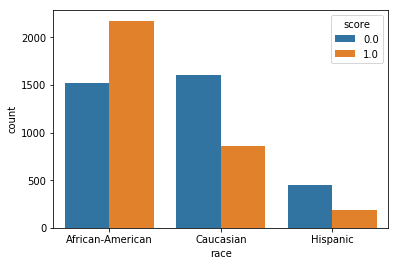

In [4]:
g = sns.countplot(x="race", hue="score", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])])

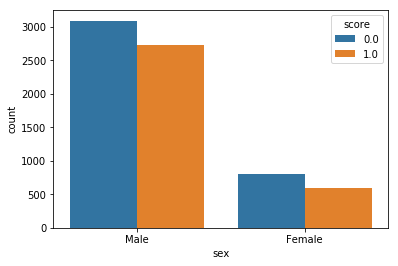

In [5]:
g = sns.countplot(x="sex", hue="score", data=df)

We note that for people under 25, COMPAS predicts higher risk at a higher rate for this younger age group than older age groups.

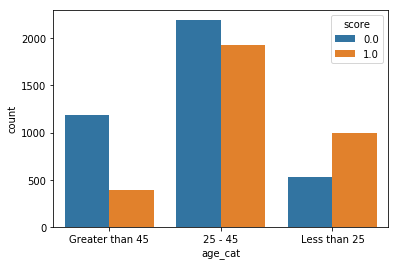

In [6]:
g = sns.countplot(x="age_cat", hue="score", data=df)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"


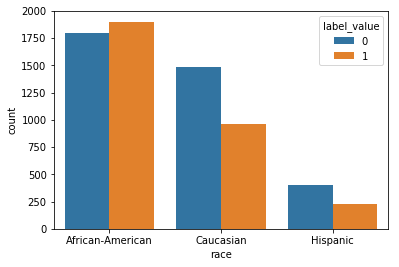

In [7]:
g = sns.countplot(x="race", hue="label_value", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])])

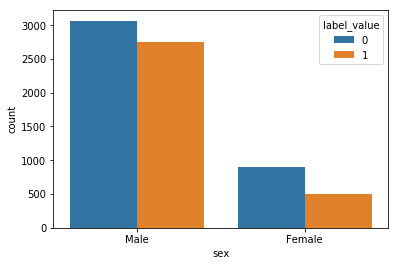

In [8]:
g = sns.countplot(x="sex", hue="label_value", data=df)

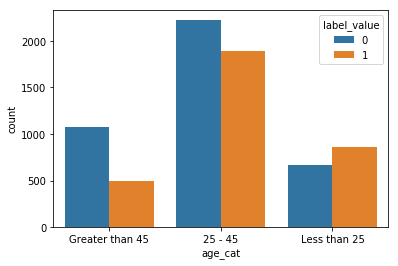

In [9]:
g = sns.countplot(x="age_cat", hue="label_value", data=df)

## Putting Aequitas to the task

The graph above shows the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39). The prior graph shows that the predictions do not match the base rates. 

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that we have multiple ways to measure bias adds complexity to the decisionmaking process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Group()
Aequitas expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this cases we include `race`, `sex` and `age_cat`. 

In [10]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [3317]}
COUNTS::: race
African-American    3696
Asian                 32
Caucasian           2454
Hispanic             637
Native American       18
Other                377
dtype: int64
COUNTS::: sex
Female    1395
Male      5819
dtype: int64
COUNTS::: age_cat
25 - 45            4109
Greater than 45    1576
Less than 25       1529
dtype: int64


The `get_crosstabs()` command tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calcuated:

| Metric | Column Name |
| --- | --- |
| $True Positive Rate$ | 'tpr' |
| $True Negative Rate$ | 'tnr' |
| $False Omission Rate$ | 'for' |
| $False Discovery Rate$ | 'fdr' |
| $False Positive Rate$ | 'fpr' |
| $False Negative Rate$ | 'fnr' |
| $Negative Predictive Value$ | 'npv' |
| $Precision$ | 'precision' |
| $Predicted Positive Ratio_k$ | 'ppr' |
| $Predicted Positive Ratio_g$ | 'pprev' |
| $Prevalence$ | 'prev' |

In [11]:
xtab.style

,attribute_name,attribute_value,k,model_id,score_threshold,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_neg,group_label_pos,group_size,total_entities,prev
0,race,African-American,3317,1,binary 0/1,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1795,1901,3696,7214,0.51434
1,race,Asian,3317,1,binary 0/1,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,8,24,0.00241182,0.25,2,3,21,6,23,9,32,7214,0.28125
2,race,Caucasian,3317,1,binary 0/1,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,1488,966,2454,7214,0.393643
3,race,Hispanic,3317,1,binary 0/1,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.0572807,0.298273,87,129,318,103,405,232,637,7214,0.364207
4,race,Native American,3317,1,binary 0/1,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,12,6,0.00361773,0.666667,3,1,5,9,8,10,18,7214,0.555556
5,race,Other,3317,1,binary 0/1,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.0238167,0.209549,36,90,208,43,244,133,377,7214,0.352785
6,sex,Female,3317,1,binary 0/1,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,591,804,0.178173,0.423656,288,195,609,303,897,498,1395,7214,0.356989
7,sex,Male,3317,1,binary 0/1,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,3066,2753,5819,7214,0.473105
8,age_cat,25 - 45,3317,1,binary 0/1,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.46824,741,706,1479,1183,2220,1889,4109,7214,0.459723
9,age_cat,Greater than 45,3317,1,binary 0/1,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.25,181,285,897,213,1078,498,1576,7214,0.31599


In [12]:
def list_metrics(group_table):
    return [col for col in group_table.columns if col in ['fpr', 'fnr', 'tpr', 'tnr', 'for', 'fdr', 'npv', 'precision', 'ppr', 'pprev', 'prev']]

In [13]:
absolute_metrics = list_metrics(xtab)

In [14]:
# View subset of calculated absolute metrics 
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,0.02,0.21,0.35
6,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
7,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
8,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
9,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32


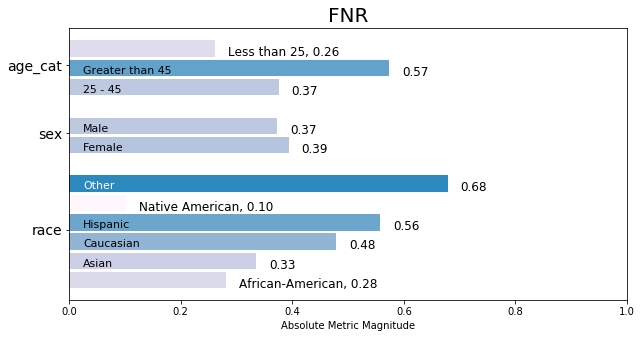

In [15]:
g = aqp.plot_group_metric(xtab, 'fnr')

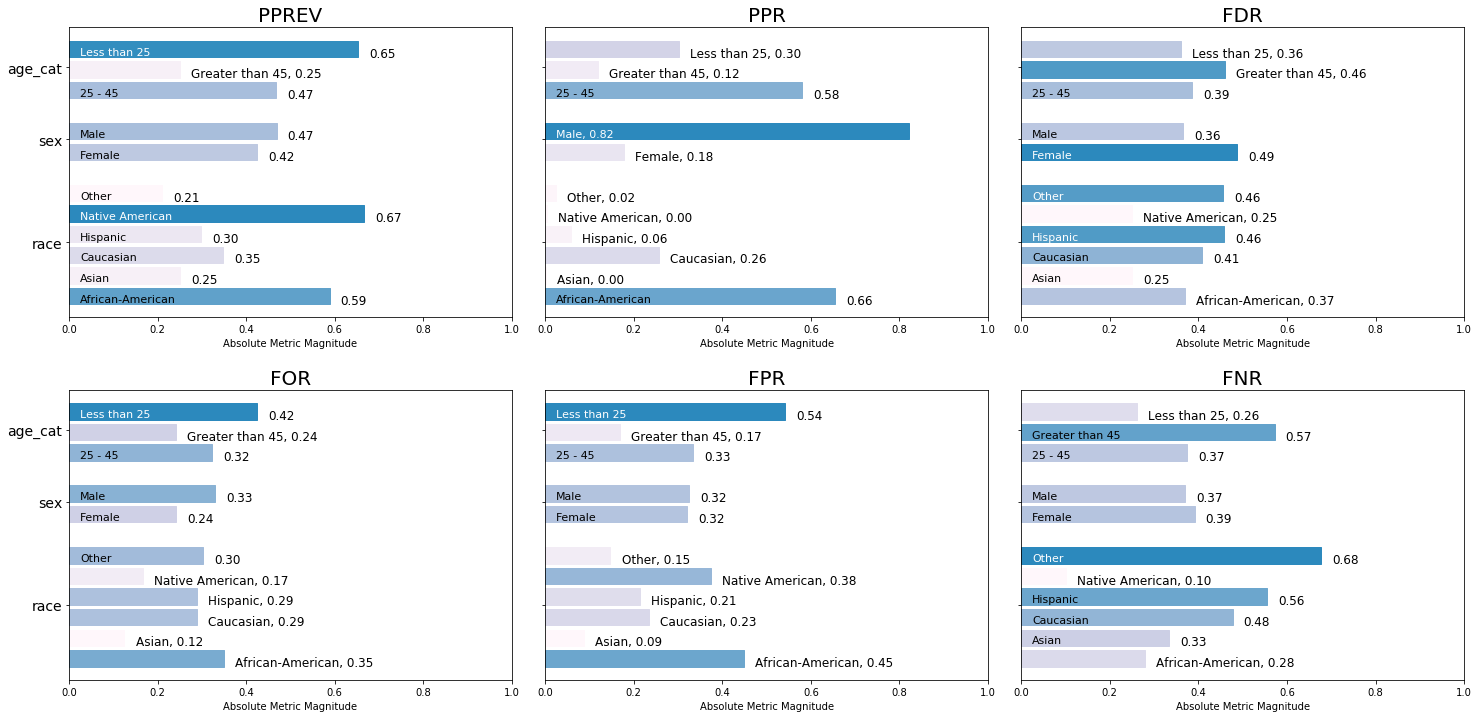

In [20]:
a = aqp.plot_group_metric_all(xtab)

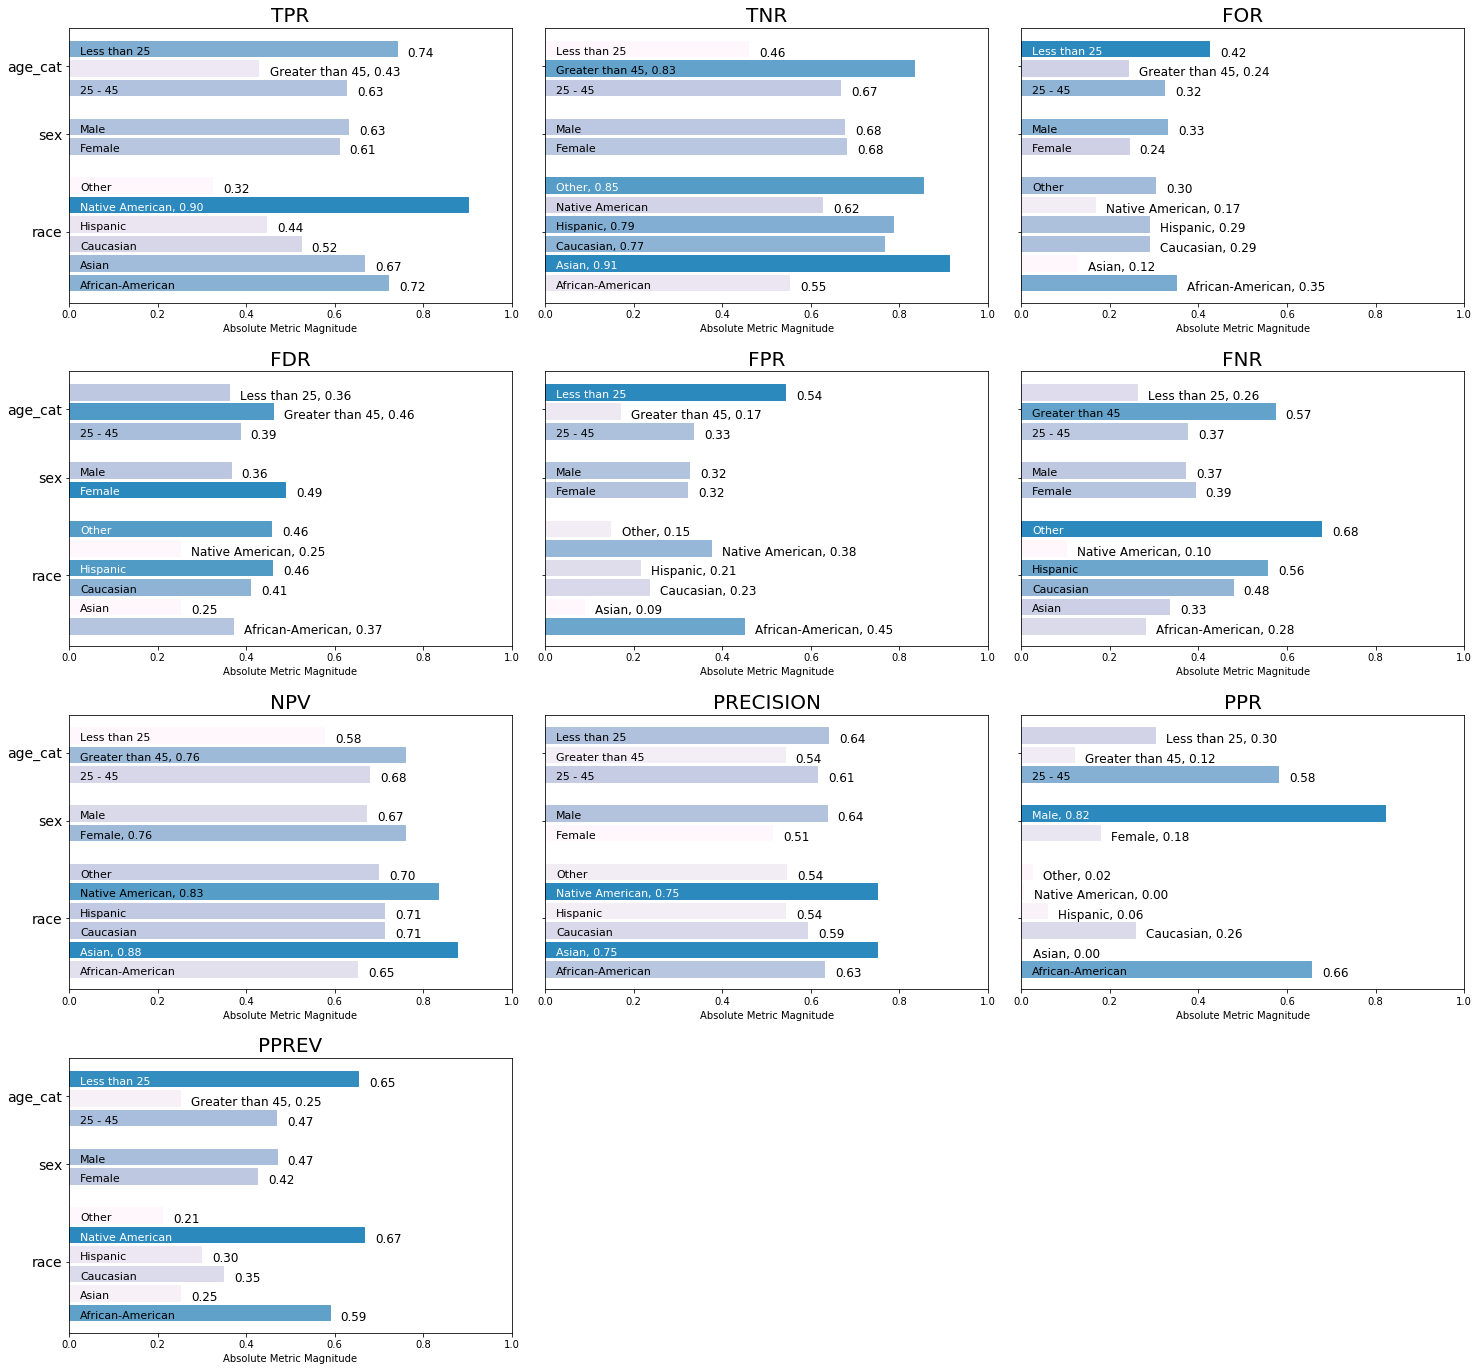

In [21]:
p = aqp.plot_group_metric_all(xtab, metrics='all')

__Interpreting the crosstab__ 
We see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that black people are far more likely to be falsely labeled as high-risk than white people. On the otherhand false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

### Bias()
We calculate disparities as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use `get_disparity_predefined_groups` which allows us to choose reference groups that clarify the output for the practitioner. Aequitas `Bias()` class includes two additional get disparity functions, which automate base group selection.


In [22]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, {'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

get_disparity_predefined_group()


In [23]:
majority_bdf = b.get_disparity_major_group(xtab)

get_disparity_major_group()


In [24]:
majority_bdf = b.get_disparity_major_group(xtab)

get_disparity_major_group()


In [25]:
min_metric_bdf = b.get_disparity_min_metric(xtab)

get_disparity_min_metric()
get_disparity_min_metric


The results are appended to the crosstab dataframe. We see a slice of this below.

In [26]:
def list_disparities(disparities_table):
    return list(disparities_table.columns[disparities_table.columns.str.contains('disparity')])

In [27]:
calculated_disparities = list_disparities(bdf)
calculated_disparities

['ppr_disparity',
 'pprev_disparity',
 'precision_disparity',
 'fdr_disparity',
 'for_disparity',
 'fpr_disparity',
 'fnr_disparity',
 'tpr_disparity',
 'tnr_disparity',
 'npv_disparity']

In [28]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728
1,race,Asian,0.009368,0.718384,1.268317,0.611748,0.433839,0.370749,0.698482,1.275248,1.192808,1.229148
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Hispanic,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346
4,race,Native American,0.014052,1.915691,1.268317,0.611748,0.578453,1.598854,0.209544,1.721584,0.816506,1.170618
5,race,Other,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490
6,sex,Female,0.216801,0.904348,0.806925,1.336425,0.734738,0.990343,1.055810,0.967101,1.004633,1.130710
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,age_cat,Greater than 45,0.204782,0.533914,0.879232,1.192804,0.746232,0.503031,1.531238,0.682963,1.248989,1.121136


__Interpreting the disparity ratios__
The differences in False Positive Rates, noted above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people. As seen above, False Discovery Rates have much less disparity (`fdr_disparity`). False discovery is the fraction of false postives over predicted positive in a group. COMPAS is calibrated to have these balanced across groups.

Notice that reference groups have disparity = 1 by design. 

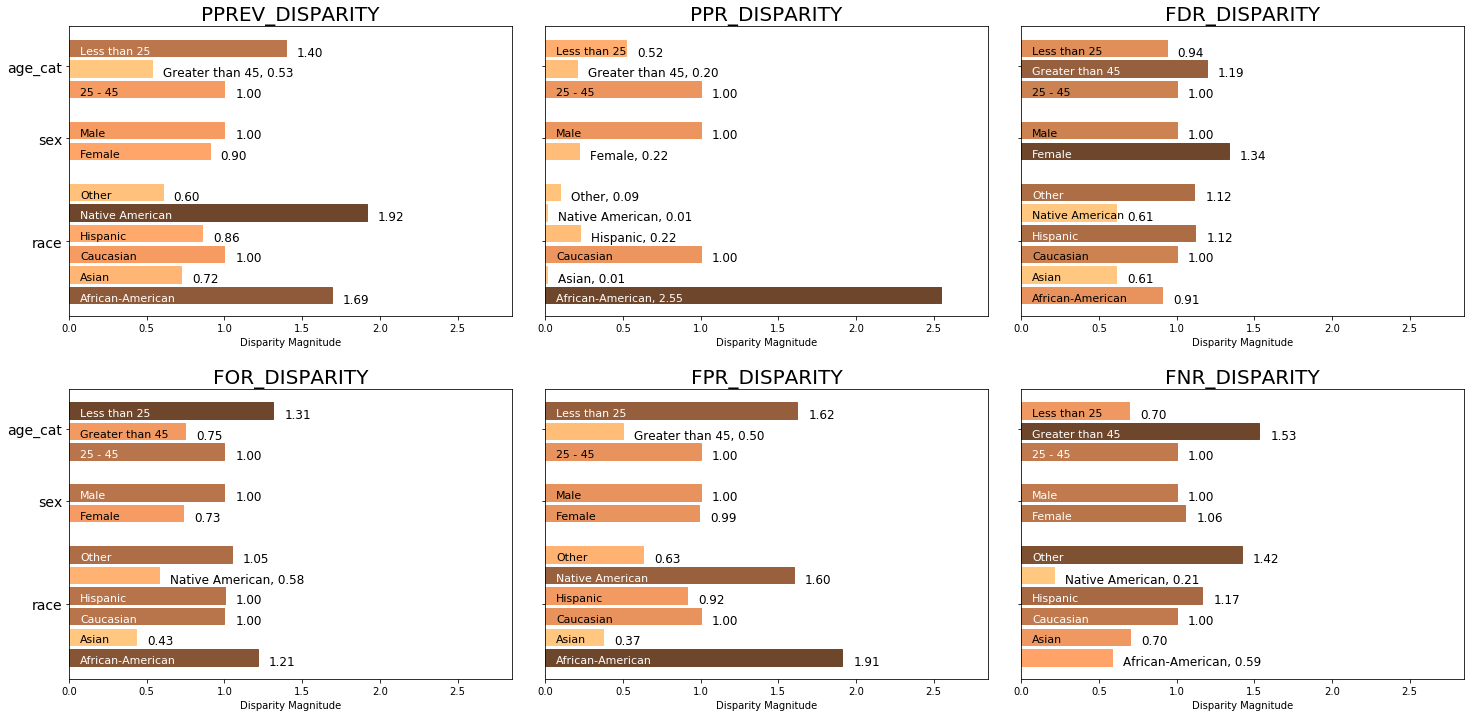

In [29]:
t = aqp.plot_disparity_all(bdf)

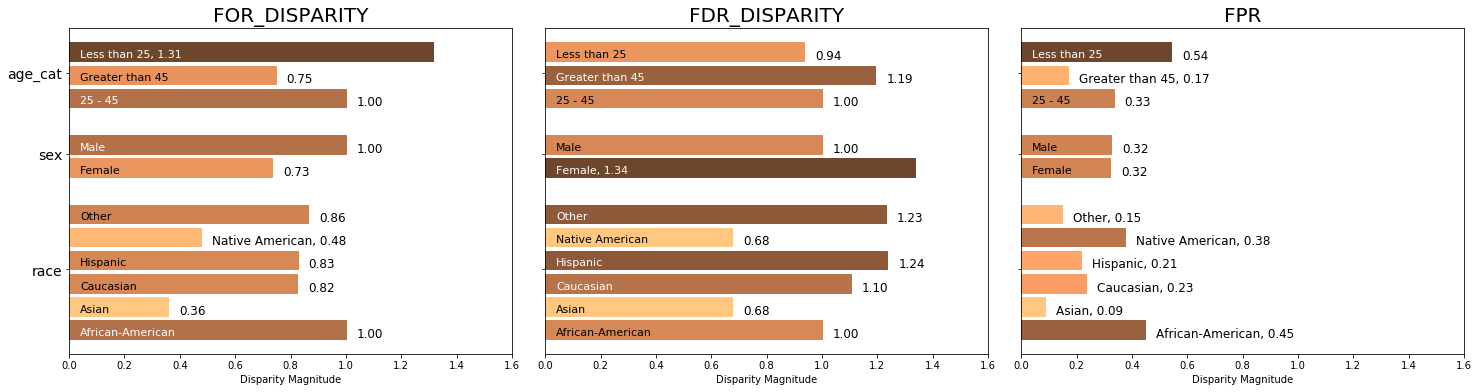

In [33]:
f = aqp.plot_disparity_all(majority_bdf, metrics=['for_disparity', 'fdr_disparity', 'fpr'], ncols=3)

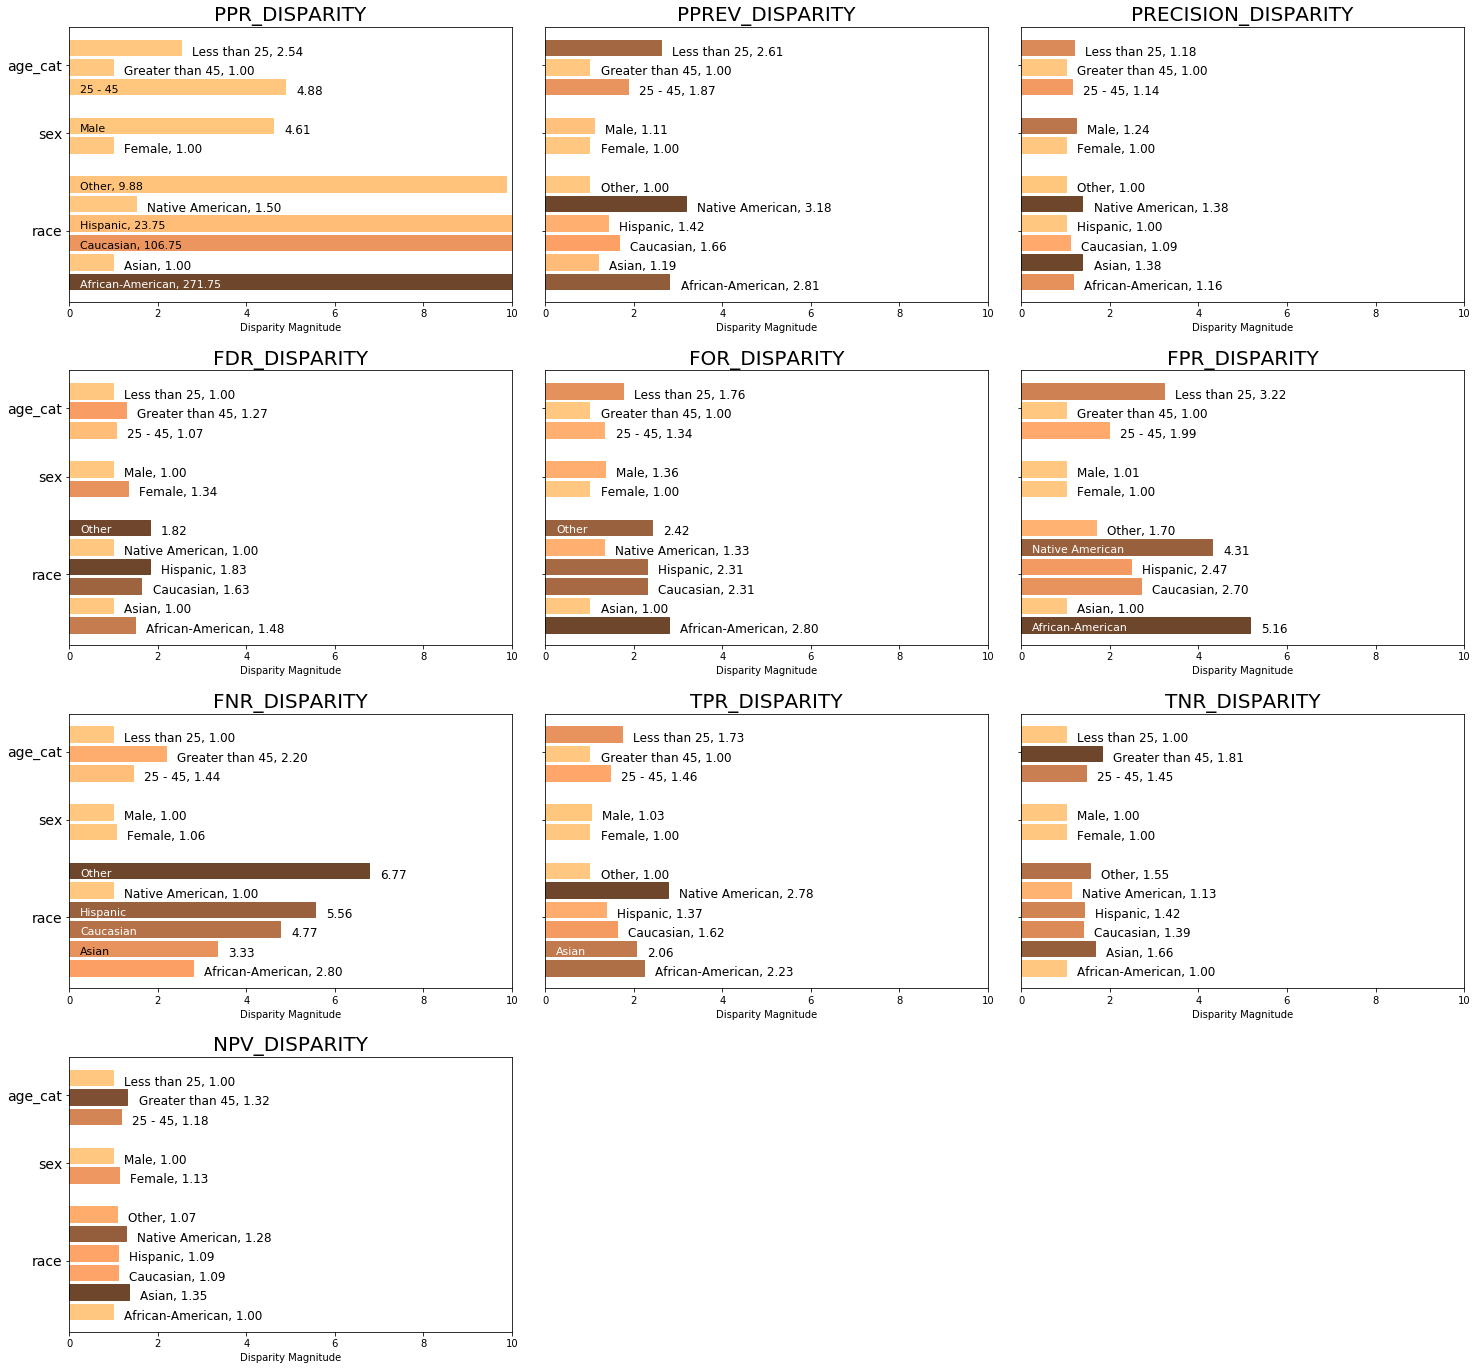

In [34]:
min_met = aqp.plot_disparity_all(min_metric_bdf, metrics='all', ncols=3)

### Fairness()
Finally, the `Fairness()` class provides three functions that provide a high level summary. Using FPR disparity as an example and the default fairness threshold, we have:

$$ 0.8 < Disparity_{FNR} =  \frac{FPR_{group}}{FPR_{base group}} < 1.25 $$ 

The `Fairness().get_group_value_fairness()` function builds on the previous dataframe.


In [35]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [36]:
fdf.style

,attribute_name,attribute_value,k,model_id,score_threshold,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_neg,group_label_pos,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,race,African-American,3317,1,binary 0/1,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1795,1901,3696,7214,0.51434,2.54567,1.69022,1.0649,0.906085,1.21315,1.91209,0.586416,1.37755,0.720526,0.913728,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False
1,race,Asian,3317,1,binary 0/1,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,8,24,0.00241182,0.25,2,3,21,6,23,9,32,7214,0.28125,0.00936768,0.718384,1.26832,0.611748,0.433839,0.370749,0.698482,1.27525,1.19281,1.22915,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
2,race,Caucasian,3317,1,binary 0/1,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,1488,966,2454,7214,0.393643,1,1,1,1,1,1,1,1,1,1,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,3317,1,binary 0/1,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.0572807,0.298273,87,129,318,103,405,232,637,7214,0.364207,0.222482,0.857099,0.916748,1.12046,1.00162,0.915887,1.16514,0.849249,1.02577,0.999346,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,True,True,True,True,True,True,True,True,True,True,True,True,False,True
4,race,Native American,3317,1,binary 0/1,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,12,6,0.00361773,0.666667,3,1,5,9,8,10,18,7214,0.555556,0.0140515,1.91569,1.26832,0.611748,0.578453,1.59885,0.209544,1.72158,0.816506,1.17062,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
5,race,Other,3317,1,binary 0/1,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.0238167,0.209549,36,90,208,43,244,133,377,7214,0.352785,0.0925059,0.602147,0.920466,1.11508,1.0482,0.629057,1.41797,0.618447,1.11366,0.98049,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,False,False,True,False,True,False,False,True,True,True,False,False,False,False,False
6,sex,Female,3317,1,binary 0/1,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,591,804,0.178173,0.423656,288,195,609,303,897,498,1395,7214,0.356989,0.216801,0.904348,0.806925,1.33642,0.734738,0.990343,1.05581,0.967101,1.00463,1.13071,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False
7,sex,Male,3317,1,binary 0/1,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,3066,2753,5819,7214,0.473105,1,1,1,1,1,1,1,1,1,1,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,a

We can assess fairness at various levels of detail. 

In [37]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_cat,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,1,binary 0/1,race,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1,binary 0/1,sex,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False


In [38]:
gof = f.get_overall_fairness(gaf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

In [39]:
fairness_grid = fdf[['attribute_name', 'attribute_value','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOR Parity', 'FNR Parity',
       'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]

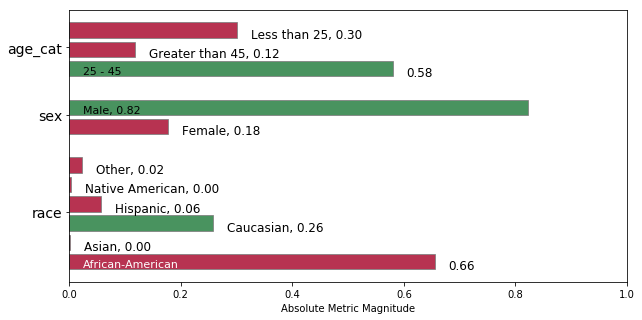

In [40]:
aqp.plot_fairness_group(fdf, group_metric='ppr')
plt.show()

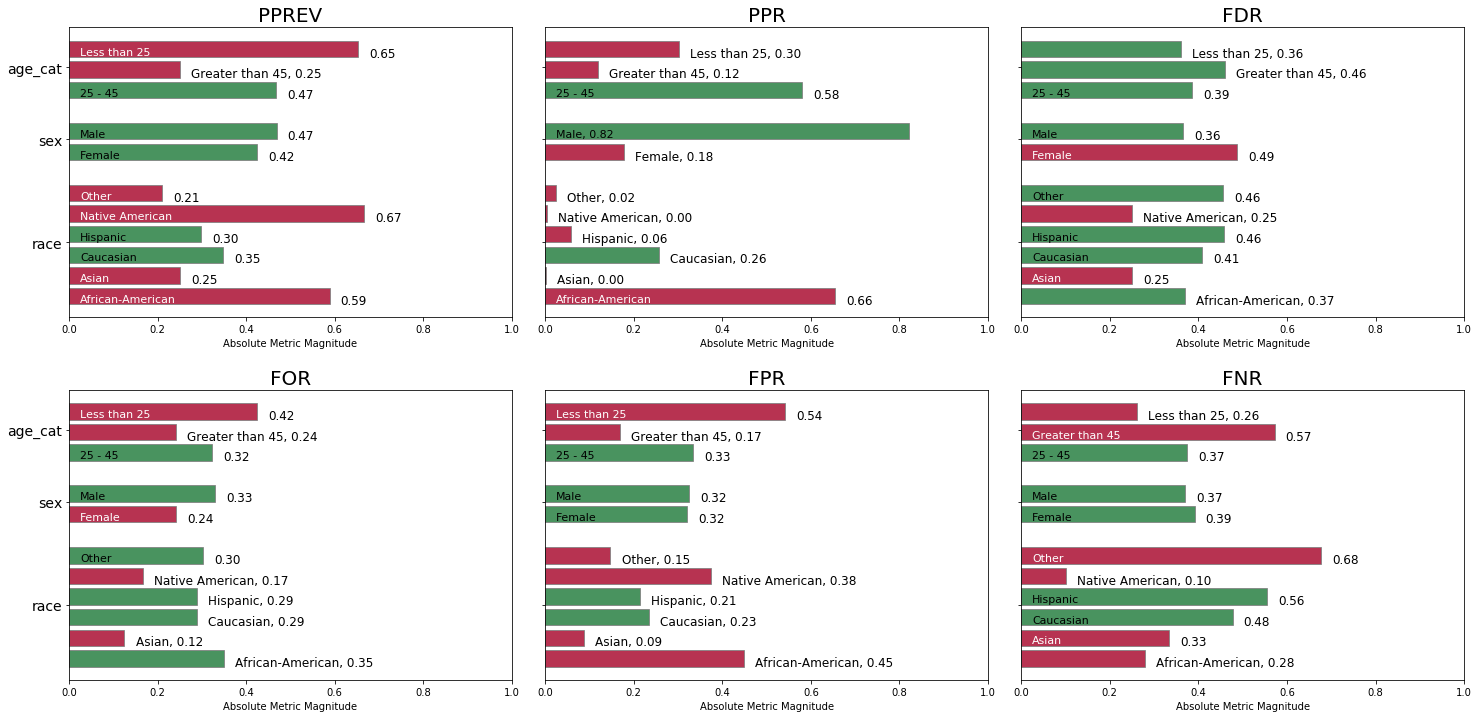

In [41]:
fg = aqp.plot_fairness_group_all(fdf)

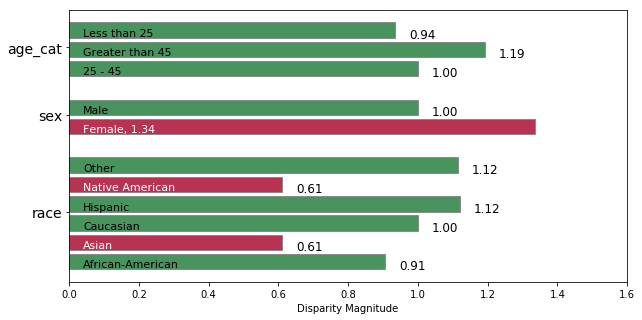

In [42]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr_disparity')

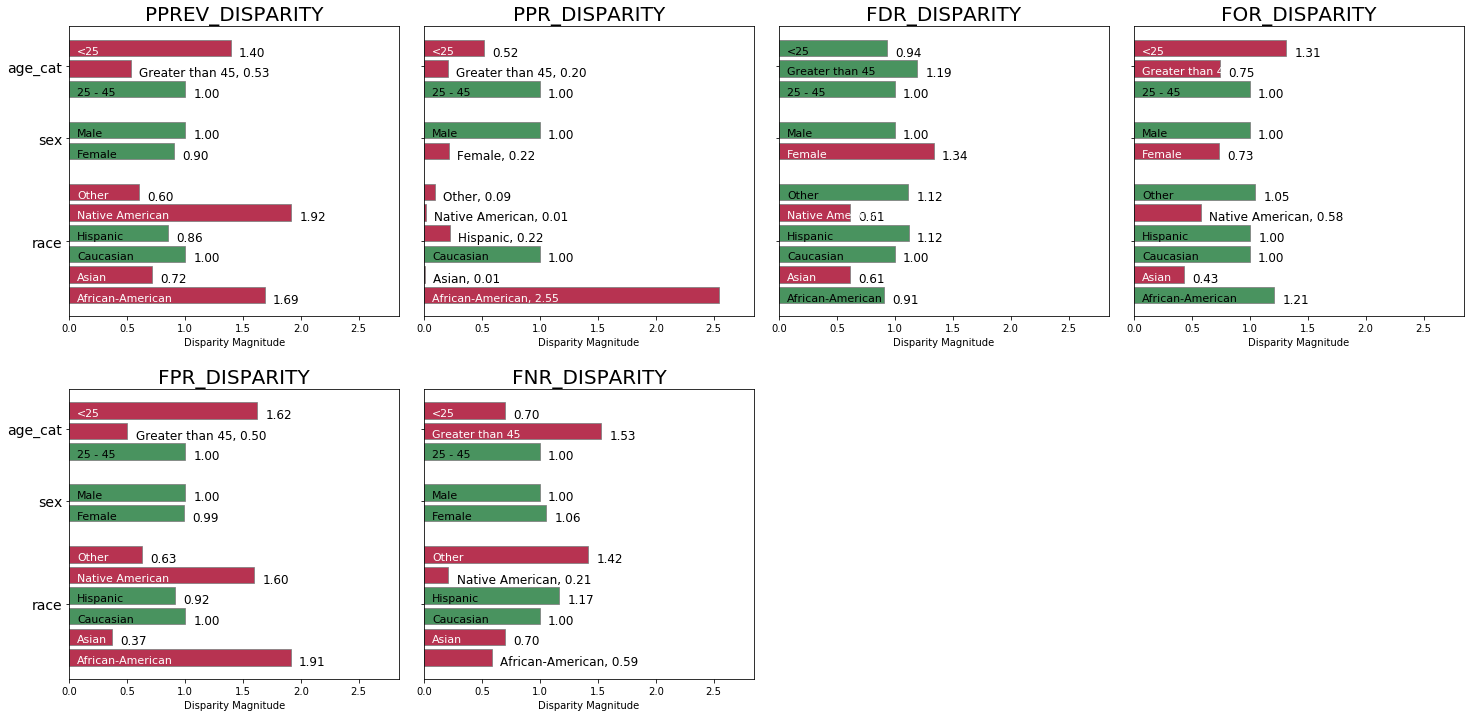

In [43]:
t = aqp.plot_fairness_disparity_all(fdf, metrics=['ppr_disparity', 'pprev_disparity', 
                                                             'tpr_disparity', 'fpr_disparity'], ncols = 4,
                                    label_dict={'Less than 25': '<25'})

__Interpreting parity__ In this case, our base groups are Caucasian for race, Male for gender, and 25-45 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

On the other hand, African-Americans are roughly twice as likely to have false positives and 40 percent less likely to false negatives. In real terms, 44.8% of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 23.4% of Caucasian non-reoffenders. This is unfair and is marked False below.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.